## <center> 数据挖掘第四次课程作业 <center>
####     <p style="text-align:right"> 吴嘉豪   _3220190894_ </p>
## 数据异常点检测 
### 1. python库引入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
import sys
import os

## 2. 处理数据集 

__1. 数据集分析 - skin_benchmarks:__   
该数据集中包含多条skin_point的数据记录，数据中给出了skin_point所对应的RGB数值，并且由GT于origin.label提供了每一条记录点是否为异常点的记录。

In [2]:
data = pd.read_csv(r"F:\course\web\homework4\homework4\skin\meta_data\skin.original.csv")
print("Skin point shape : " , data.shape)
data.head()

Skin point shape :  (245057, 4)


,Y,R,G,B
0,1,74,85,123
1,1,73,84,122
2,1,72,83,121
3,1,70,81,119
4,1,70,81,119


由上面的数据读取可以看出，鉴于处理效率，仅在实验中使用了该数据总计包括245057条数据，在这里我们提取器中的R\G\B三种属性作为属性值，同时提取label列中的值(0/1)作为Ground Truth，进行数据点异常的判断。选取的方法包括：LOF(Proximity) / 

In [3]:
seqset = data[["R","G","B"]]
labelset = data["Y"]
seq = seqset.values
label = 2 - labelset.values 

# Method 1  'kNN'
import random
from sklearn import preprocessing
from sklearn.utils import shuffle
seq,label = shuffle(seq,label)
contamination = sum(label == 1) / sum(label == 0)
print("数据及污染程度:" , contamination)

dvlen = int(0.7 * len(seq))
X_train = seq[:dvlen]
X_test = seq[dvlen:]
Y_train = label[:dvlen]
Y_test = label[dvlen:]
print("Dataset shape:",X_train.shape , X_test.shape)
print("Label shape:",Y_train.shape , Y_test.shape)

# 标准化
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

数据及污染程度: 0.2618925014675743
Dataset shape: (171539, 3) (73518, 3)
Label shape: (171539,) (73518,)


In [4]:
from pyod.utils.data import evaluate_print

contamination = 0.25
# clf = KNN(n_neighbors = 30 , method='median', metric = 'cityblock') 
clf = KNN(contamination = contamination , n_neighbors = 10) 
clf.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_ 
y_train_scores = clf.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = clf.predict(X_test) 
y_test_scores = clf.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("KNN", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("KNN", Y_test, y_test_scores)


On Training Data:
KNN ROC:0.6693, precision @ rank n:0.2791

On Test Data:
KNN ROC:0.6687, precision @ rank n:0.2742


In [5]:
# Method 2  LOF
C_LOF = LOF(contamination = contamination) 
C_LOF.fit(X_train)# 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_LOF.labels_ 
y_train_scores = C_LOF.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_LOF.predict(X_test) 
y_test_scores = C_LOF.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_LOF", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_LOF", Y_test, y_test_scores)


On Training Data:
Method_LOF ROC:0.5684, precision @ rank n:0.2786

On Test Data:
Method_LOF ROC:0.5709, precision @ rank n:0.272


In [6]:
# Method 3  PCA
C_PCA = PCA(n_components = 2, contamination = contamination) 
C_PCA.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_PCA.labels_ 
y_train_scores = C_PCA.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_PCA.predict(X_test) 
y_test_scores = C_PCA.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_PCA", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_PCA", Y_test, y_test_scores)


On Training Data:
Method_PCA ROC:0.1259, precision @ rank n:0.0036

On Test Data:
Method_PCA ROC:0.1267, precision @ rank n:0.0025


In [7]:
# Method 4 IForest
C_IForest = IForest(contamination = contamination,n_estimators = 1000) 
C_IForest.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_IForest.labels_ 
y_train_scores = C_IForest.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_IForest.predict(X_test) 
y_test_scores = C_IForest.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_IForest", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_IForest", Y_test, y_test_scores)


On Training Data:
Method_IForest ROC:0.6641, precision @ rank n:0.0982

On Test Data:
Method_IForest ROC:0.6643, precision @ rank n:0.0935


从上面尝试的及几种方法来看，总体来说KNN与IForest的表现结果最好，相应的其计算异常点的消耗时间也更长，而PCA的表现分类结果不好，这里我认为可能是因为Skin的属性仅仅是三维数据，因而PCA将为并不能有效地进行异常点监测的缘故。

__2. 数据集分析 - pageb_benchmarks:__   
该数据集中包含多条pageb_point的数据记录，数据中给出了pageb所对应的十维属性数值，并且由ground.truth属性提供了每一条记录点是否为异常点的记录。

In [8]:
from time import *
data = pd.read_csv(r"F:\course\web\homework4\homework4\pageb\meta_data\pageb.preproc.csv")
print("Pageb_origin dataset: " , data.shape)
data.head()

Pageb_origin dataset:  (5473, 15)


,point.id,motherset,origin,original.label,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9
0,pageb_point_0001,pageb,multiclass,1,nominal,-0.288664,-0.719726,-0.239908,-0.402361,0.176407,-0.750332,-0.056302,-0.277038,-0.381667,-0.601661
1,pageb_point_0002,pageb,multiclass,1,nominal,-0.235923,-0.719726,-0.238465,-0.409949,0.339552,0.562209,-0.037917,-0.273889,-0.374226,-0.607638
2,pageb_point_0003,pageb,multiclass,1,nominal,-0.235923,-0.623842,-0.224855,-0.350250,-0.459293,-0.258129,-0.025902,-0.263656,-0.351372,-0.595684
3,pageb_point_0004,pageb,multiclass,1,nominal,-0.288664,-0.719726,-0.239908,-0.402361,0.013263,-0.246410,-0.027350,-0.277825,-0.380073,-0.619592
4,pageb_point_0005,pageb,multiclass,1,nominal,-0.235923,-0.754593,-0.243414,-0.431673,0.738974,0.931362,-0.057460,-0.280974,-0.384856,-0.613615


In [21]:
cols = [i for i in data.columns if i not in ["motherset","ground.truth","point.id","origin","original.label"]]
seqset = data[cols]
labelset = data["ground.truth"]
seq = seqset.values
label = np.where(labelset == "nominal" , 0 ,1)

# Method 1  'kNN'
seq,label = shuffle(seq,label)
contamination = sum(label == 1) / sum(label == 0)
print("数据及污染程度:" , contamination)

dvlen = int(0.85 * len(seq))
X_train = seq[:dvlen]
X_test = seq[dvlen:]
Y_train = label[:dvlen]
Y_test = label[dvlen:]
print("Dataset shape:",X_train.shape , X_test.shape)
print("Label shape:",Y_train.shape , Y_test.shape)

# 标准化
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

数据及污染程度: 0.11398330958681051
Dataset shape: (4652, 10) (821, 10)
Label shape: (4652,) (821,)


In [22]:
# KNN 
begin_time = time()
contamination = 0.10
# clf = KNN(n_neighbors = 30 , method='median', metric = 'cityblock') 
clf = KNN(contamination = contamination , n_neighbors = 30, metric = 'cityblock') 
clf.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = clf.labels_ 
y_train_scores = clf.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = clf.predict(X_test) 
y_test_scores = clf.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("KNN", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("KNN", Y_test, y_test_scores)
end_time = time()
run_time = end_time-begin_time
print ('运行时间：',run_time)


On Training Data:
KNN ROC:0.8131, precision @ rank n:0.4544

On Test Data:
KNN ROC:0.7957, precision @ rank n:0.4494
运行时间： 0.46399998664855957


In [23]:
# Method 2  LOF
begin_time = time()
C_LOF = LOF(contamination = contamination) 
C_LOF.fit(X_train)# 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_LOF.labels_ 
y_train_scores = C_LOF.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_LOF.predict(X_test) 
y_test_scores = C_LOF.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_LOF", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_LOF", Y_test, y_test_scores)
end_time = time()
run_time = end_time-begin_time
print ('运行时间：',run_time)


On Training Data:
Method_LOF ROC:0.7509, precision @ rank n:0.3503

On Test Data:
Method_LOF ROC:0.6988, precision @ rank n:0.3708
运行时间： 0.35699987411499023


In [24]:
# Method 3  PCA
begin_time = time()
C_PCA = PCA(n_components = 2, contamination = contamination) 
C_PCA.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_PCA.labels_ 
y_train_scores = C_PCA.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_PCA.predict(X_test) 
y_test_scores = C_PCA.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_PCA", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_PCA", Y_test, y_test_scores)
end_time = time()
run_time = end_time-begin_time
print ('运行时间：',run_time)


On Training Data:
Method_PCA ROC:0.8923, precision @ rank n:0.4246

On Test Data:
Method_PCA ROC:0.8934, precision @ rank n:0.4719
运行时间： 0.031999826431274414


In [27]:
# Method 4 IForest
begin_time = time()
C_IForest = IForest(contamination = contamination,n_estimators = 300) 
C_IForest.fit(X_train) # 使用X_train训练检测器clf

# 返回训练数据X_train上的异常标签和异常分值
y_train_pred = C_IForest.labels_ 
y_train_scores = C_IForest.decision_scores_ 

# 用训练好的clf来预测未知数据中的异常值
y_test_pred = C_IForest.predict(X_test) 
y_test_scores = C_IForest.decision_function(X_test) 

# 输出评估结果
print("\nOn Training Data:")
evaluate_print("Method_IForest", Y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print("Method_IForest", Y_test, y_test_scores)
end_time = time()
run_time = end_time-begin_time
print ('运行时间：',run_time)


On Training Data:
Method_IForest ROC:0.8963, precision @ rank n:0.4055

On Test Data:
Method_IForest ROC:0.8876, precision @ rank n:0.4045
运行时间： 2.071000099182129


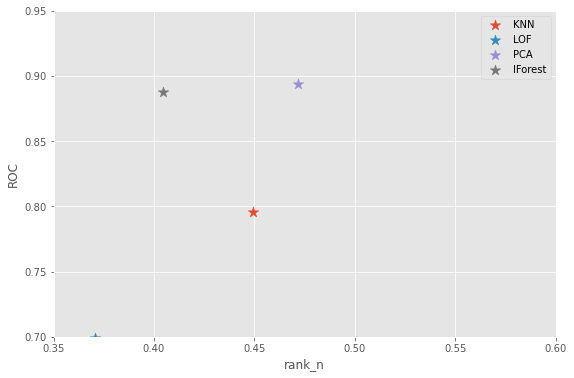

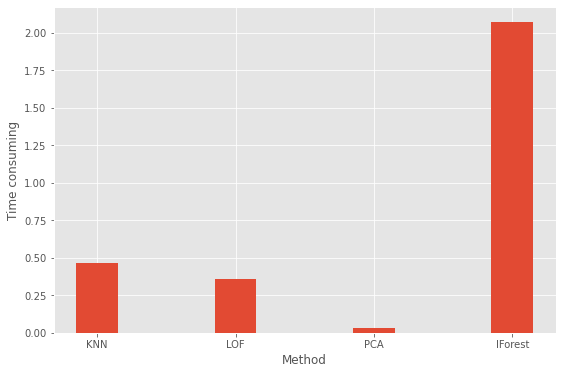

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
ROC = np.array([0.7957,0.6988,0.8934,0.8876])
rank_n = np.array([0.4494 ,0.3708, 0.4719, 0.4045])
name = ["KNN" , "LOF" , "PCA","IForest"]
perfomance = np.array([ROC , rank_n])
time_c = np.array([0.46399998664855957, 0.35699987411499023,0.031999826431274414,2.071000099182129])
for i in range(4):
    plt.scatter(rank_n[i] ,ROC[i] , s = 120 ,marker = "*")
plt.xlabel("rank_n")
plt.ylabel("ROC")
plt.xlim([0.35 , 0.6])
plt.ylim([0.7 , 0.95])
# plt.grid()
plt.legend(name)
plt.show()

plt.figure(figsize=(9,6))
plt.bar(name, time_c ,width=0.3)
plt.xlabel("Method")
plt.ylabel("Time consuming")
# plt.grid()
plt.show()

从这里我们可以看出，在面对像pageb这样的更高位属性的时候，像PCA这样的方法则表现出了更好的异常点检测性能，比KNN与LOF这样的检测算法表现更好，然而基于类似Ensemble的IForest方法同样表现出了较好的异常点检测能力，然而这也代表着训练多个分支的时间消耗更长。

__Github:__  https://github.com/FadedFate/Data_Homeworkw4